<a href="https://colab.research.google.com/github/taiyang2525/Prog2kakushin/blob/main/work3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colabのセッションをリセットする（必要に応じて）
#!kill -9 -1

# 名刺リーダー
名刺リーダーです．名刺の表面をPDFでアップロードすると自動的に名前，勤務先，電話番号をまとめた連絡先ファイル（vcard形式）で出力します．

日本語の名刺に対応しています．

読み込み精度が少し低いですが，ご容赦ください．

もしよろしければ，先生のお名刺もお試しください．

名前の読み取り精度に一部難があります．あらかじめご了承ください．

In [ ]:
#名刺サンプルです．読み込む名刺がなければ，ここでダウンロードください
!wget "https://drive.google.com/uc?export=download&id=1fBQCKfn9rK_ITapU0WoRPIjKUfXX0RYe" -O images.zip
!unzip -o images.zip

--2024-01-16 10:38:26--  https://drive.google.com/uc?export=download&id=1fBQCKfn9rK_ITapU0WoRPIjKUfXX0RYe
Resolving drive.google.com (drive.google.com)... 108.177.96.139, 108.177.96.138, 108.177.96.101, ...
Connecting to drive.google.com (drive.google.com)|108.177.96.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1fBQCKfn9rK_ITapU0WoRPIjKUfXX0RYe&export=download [following]
--2024-01-16 10:38:26--  https://drive.usercontent.google.com/download?id=1fBQCKfn9rK_ITapU0WoRPIjKUfXX0RYe&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.127.132, 2a00:1450:4013:c07::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.127.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 516568 (504K) [application/octet-stream]
Saving to: ‘images.zip’

images.zip          100%[===================>] 504.46K  --.-KB/s   

#環境構築

一度だけ実行してください

In [ ]:
!pip install pymupdf
!pip install PyPDF2
!apt install tesseract-ocr libtesseract-dev tesseract-ocr-jpn
!pip install pyocr
!pip install urlextract

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libarchive-dev libleptonica-dev tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  libarchive-dev libleptonica-dev libtesseract-dev tesseract-ocr tesseract-ocr-eng
  tesseract-ocr-jpn tesseract-ocr-osd
0 upgraded, 7 newly installed, 0 to remove and 24 not upgraded.
Need to get 9,950 kB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libarchive-dev amd64 3.6.0-1ubuntu1 [581 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libleptonica-dev amd64 1.82.0-3build1 [1,56

#名刺データ（PDF）から連絡先情報を作成する

In [ ]:
#ライブラリのインポート
import cv2
import os
from google.colab import files
import PyPDF2
import fitz  # PyMuPDFのモジュール
from PIL import Image
import pyocr
from google.colab.patches import cv2_imshow
import re
import unicodedata
import numpy as np
from urlextract import URLExtract

Saving meishi2.pdf to meishi2 (1).pdf


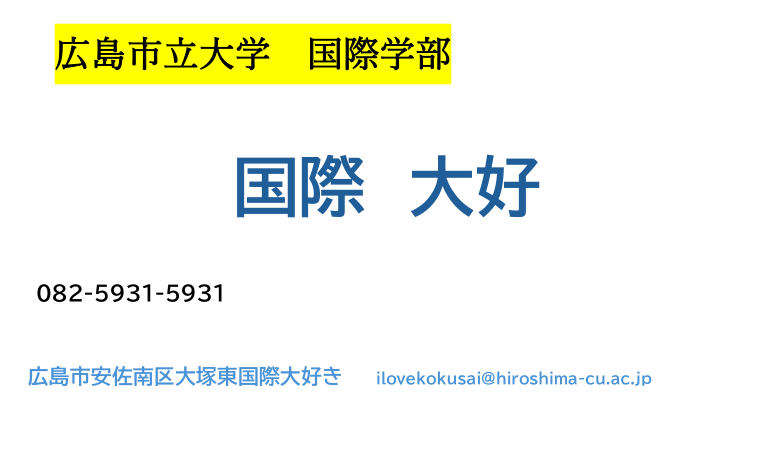

読み込んだ名刺を表示しています
（PDFの１ページ目を読み込みます．）
お名前は次のように読み込まれました．： 国際大好
間違いがあれば入力してください．なければそのままエンターを押してください
勤務先は次のように読み込まれました．： 広島市立大学
間違いがあれば入力してください．なければそのままエンターを押してください：
電話番号は次のように読み込まれました．： 08259315931
間違いがあれば入力してください．なければそのままエンターを押してください：
メールアドレスは次のように読み込まれました．： iloyekokusai@hiroshima-cuac.jp
間違いがあれば入力してください．なければそのままエンターを押してください：ilovekokusai@hiroshima-cu.ac.jp


In [ ]:
def match(list, word):
  for i in range(len(list)):
    if word in list[i]:
      return i
  return -1

def del_hy(phone):
  num = ""
  for i in phone:
    if i != "-":
      num = num + i
  return num


def zenkaku(FN):
  for i in FN:
    if unicodedata.east_asian_width(i) != "W":
      return False
  return True


def find_fullname(content):
  for i in range(len(content)-1):
    #日本人の姓名は4文字以内と仮定し，かつ次のインデックスに名前が格納されていると仮定
    if 0 < len(content[i]) <= 4:
      fullname = content[i] + content[i + 1]
      if zenkaku(fullname) == True:
        return fullname
  return ""

def find_org(content):
  if match(content, "大学") >= 0:
    company = content[match(content, "大学")]
  elif match(content, "会社") >= 0:
    company = content[match(content, "会社")]
  else:
    company = ""
  return company

def find_number(txt1):
  pattern = r"\d{2,4}-\d{2,4}-\d{4}"
  if re.search(pattern, txt1) is not None:
    number = re.search(pattern, txt1).group()
    number = del_hy(number)
  else:
    pattern = r"\d{10, 11}"
    if re.search(pattern, txt1) is not None:
      number = re.search(pattern, txt1).group()
    else:
      number = ""
  return number

def find_email(txt1):
  extractor = URLExtract()
  extractor.extract_email=True
  urls = extractor.find_urls(txt1)
  for i in urls:
    if i.find("@") >0:
      return i
  return ""



def cv2pil(image):
    ''' OpenCV型 -> PIL型 '''
    new_image = image.copy()
    if new_image.ndim == 2:  # モノクロ
        pass
    elif new_image.shape[2] == 3:  # カラー
        new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
    elif new_image.shape[2] == 4:  # 透過
        new_image = cv2.cvtColor(new_image, cv2.COLOR_BGRA2RGBA)
    new_image = Image.fromarray(new_image)
    return new_image


def information_reader(f_name):
  #色を変えながら複数回名刺情報を読み取る
  card = ["", "", "", ""] #名前，所属，電話番号，メール
  img_color = Image.open(f_name)
  #グレースケール
  img_gray = cv2.imread(f_name, cv2.IMREAD_GRAYSCALE)
  #２値化用
  img_bit = cv2.imread(f_name, cv2.IMREAD_GRAYSCALE)
  h = img_bit.shape[0] # 画像の高さ
  w = img_bit.shape[1] # 画像の幅

  th = 100  # しきい値

  for iy in range(h):
    for ix in range(w):
      if img_bit[iy,ix] >= th:
        img_bit[iy,ix] = 255
      else:
        img_bit[iy,ix] = 0
  #RGBに変える
  img_gray = cv2.cvtColor(img_gray, cv2.COLOR_BGR2RGB)
  img_bit = cv2.cvtColor(img_bit, cv2.COLOR_BGR2RGB)
  #pillowに変える
  img_gray = cv2pil(img_gray)
  img_bit = cv2pil(img_bit)

  #リスト化してまとめて処理する
  imgs = [img_color, img_gray, img_bit]
  #OCRの情報を読み込む
  tools = pyocr.get_available_tools()
  tool = tools[0]

  content = [] #名刺の読み込み情報

  #forでまとめて処理
  for i in imgs:
    #読み込んだテキスト
    txt1 = tool.image_to_string(
      i,
      lang='jpn+eng',
      builder=pyocr.builders.TextBuilder(tesseract_layout=6)
    )


    #処理用変数
    aptext = ""

    #リストで日本語の単語に分ける
    for w in txt1:
      if w == " " or w == "\n":
        content.append(aptext)
        aptext = ""
      else:
        aptext = aptext + w
    #find_fullname関数に渡す
    #既にフルネームが読み込まれていないなら
    if card[0] == "" and find_fullname(content) != "":
      card[0] = find_fullname(content)
    if card[1] == "" and find_org(content) != "":
      card[1] = find_org(content)
    if card[2] == "" and find_number(txt1) != "":
      card[2] = find_number(txt1)
    if card[3] == "" and find_email(txt1) != "":
      card[3] = find_email(txt1)
    content = []
  return card



uploaded = files.upload()
if list(uploaded.keys())[0].endswith('.pdf') == False:
  print('pdfファイルをアップロードしてください．')
else:
  #PDFの最初の１ページのみ
      with open(list(uploaded.keys())[0], 'rb') as file:
        # PyPDF2のPdfFileReaderオブジェクトを作成
        pdf_reader = PyPDF2.PdfReader(file)

        # 新しいPdfFileWriterオブジェクトを作成
        pdf_writer = PyPDF2.PdfWriter()

        # 最初のページを抽出して追加
        first_page = pdf_reader.pages[0]

        pdf_writer.add_page(first_page)

        # 出力ファイルに書き込む
        with open('bcard.pdf', 'wb') as output_file:
            pdf_writer.write('bcard.pdf')

      #画像変換

      # PDFを画像に変換

      # 1つの画像をPDFに変換する
      pdf_document = fitz.open('bcard.pdf')

      # 最初のページを取得
      first_page = pdf_document[0]

      # ページを画像に変換
      image = first_page.get_pixmap(matrix=fitz.Matrix(3, 3))

      # 画像を保存
      image.save('bcard.png')

      # PDFを閉じる
      pdf_document.close()

      img = cv2.imread('bcard.png')

      cv2_imshow(img)

      print('読み込んだ名刺を表示しています')
      print('（PDFの１ページ目を読み込みます．）')

      data = information_reader('bcard.png')
      name = data[0]
      company = data[1]
      number = data[2]
      email = data[3]

      #名前の処理
      if name == "":
        print('お名前の読み込みに失敗しました．')
        name = input('お名前を入力してください．：')
      else:
        print('お名前は次のように読み込まれました．：', name)
        name = input('間違いがあれば入力してください．なければそのままエンターを押してください') or name

      #会社名処理
      if company == "":
        print('勤務先の読み込みに失敗しました．')
        company = input('勤務先を入力してください．：')
      else:
        print('勤務先は次のように読み込まれました．：', company)
        company = input('間違いがあれば入力してください．なければそのままエンターを押してください：') or company

      #電話番号
      if number == "":
        print('電話番号の読み込みに失敗しました．')
        number = input('電話番号を入力してください．：')
      else:
        print('電話番号は次のように読み込まれました．：', number)
        number = input('間違いがあれば入力してください．なければそのままエンターを押してください：') or number
        #ハイフンを削除
        number = del_hy(number)
            #電話番号
      if email == "":
        print('メールアドレスの読み込みに失敗しました．')
        email = input('メールアドレスを入力してください．：')
      else:
        print('メールアドレスは次のように読み込まれました．：', email)
        email = input('間違いがあれば入力してください．なければそのままエンターを押してください：') or email

## 連絡先データとして出力

以下のセルを実行するとvcf形式で読み込んだ名刺に記載の名前，勤務先，電話番号，メールアドレスを出力します！

In [ ]:
with open(name + '.vcf', 'w', encoding = 'utf-8') as f:
  f.write('BEGIN:VCARD\n')
  f.write('VERSION:3.0\n')
  f.write('FN:' + name + '\n')
  f.write('ORG:' + company + '\n')
  f.write('TEL:' + number + '\n')
  f.write('EMAIL:' + email +'\n')
  f.write('END:VCARD')
print(name + 'さんのデータを出力しました．')

国際大好さんのデータを出力しました．
